In [11]:
import pandas as pd
pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings('ignore')

import numpy as np
SEED = 800

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')
%matplotlib inline 

# Carregar os dados e manter indice original para cruzamento com outros dataframes

In [2]:
train = pd.read_csv('../desafio/train.csv')
train.reset_index(inplace=True)
train.columns = ['index_origin','target','inputs']

## Converter dict para dataframes
Desta forma será mais fácil realizar as análises e tratamento dos dados. 
Mantemos o índice original como uma nova coluna caso precisarmos voltar ao dataframe original

[Faltam ajustes de performance ...]

Keydown : O evento keydown é disparado quando uma tecla é pressionada. Diferente do evento keypress, o keydown é disparado para teclas que produzem e que não produzem um caractere.

Keyup : O evento keyup é acionado quando uma tecla é liberada.

In [4]:
train.head()

,index_origin,target,inputs
0,0,0,"{'keyboard': {'keyup': [{'code': 467, 'tick': ..."
1,1,1,"{'keyboard': {'keyup': [{'code': 1, 'tick': 4}..."
2,2,0,"{'keyboard': {'keyup': [{'code': 32, 'tick': 1..."
3,3,0,"{'keyboard': {'keyup': [{'tick': 109, 'code': ..."
4,4,1,"{'keyboard': {'keyup': [{'tick': 5, 'code': 10..."


In [ ]:
df_keyup = pd.DataFrame(columns=['code','tick','index_origin'])
df_keydown = pd.DataFrame(columns=['code','tick','index_origin'])

# loop into dataframe to be able to transform dict into new dataframes
for index,row in train.iterrows():

    # keydown
    df_keydown = pd.concat([pd.DataFrame.from_dict(eval(row['inputs'])['keyboard']['keydown']),df_keydown],sort=False)
    df_keydown = df_keydown.fillna(index).astype(int)
    
    # keyup
    try:
        df_keyup = pd.concat([pd.DataFrame.from_dict(eval(row['inputs'])['keyboard']['keyup']),df_keyup],sort=False)
        df_keyup = df_keyup.fillna(index).astype(int)
    except:
        pass

# Persistir dataframes para não ser necessário reprocessamento do dict
df_keydown.to_pickle('dataframe_keydown')
df_keyup.to_pickle('dataframe_keyup')
train.to_pickle('dataframe_train') # congelar os mesmos indices

### Caso já tenhamos processado o dict basta carregarmos o pickle

In [6]:
#df_keydown = pd.read_pickle('dataframe_keydown')
#df_keyup = pd.read_pickle('dataframe_keyup')
#train = pd.read_pickle('dataframe_train')

In [7]:
print('Quantidade de train {}'.format(train.index_origin.count()))
print('Quantidade de Keydown {}'.format(df_keydown.tick.count()))
print('Quantidade de Keyup {}'.format(df_keyup.tick.count()))

Quantidade de train 36356
Quantidade de Keydown 357782
Quantidade de Keyup 342996


## Adicionando campo sequencial por grupo baseado no tick

In [8]:
df_keydown['seq'] = df_keydown.groupby(['index_origin'])['tick'].rank(ascending=True,method='first')
df_keyup['seq'] = df_keyup.groupby(['index_origin'])['tick'].rank(ascending=True,method='first')

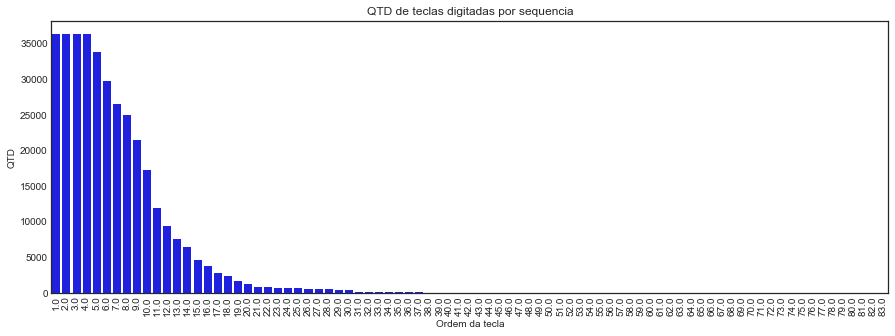

In [13]:
plt.figure(figsize=(15,5))

sns.countplot(x='seq', 
            data=df_keydown,
            color='blue'
           )

plt.xticks(rotation= 90)
plt.xlabel('Ordem da tecla')
plt.ylabel('QTD')

plt.title("QTD de teclas digitadas por sequencia")

plt.show()

### Itens que podem ser interessantes analisarmos:
* tempo entre uma tecla e outra ser pressionada [done]
* tempo total de digitação [done]
* teclas fora de ordem (entre tick e code) [...]
* quantidade total de teclas pressionadas [done]
* quantidade distinta de teclas pressionadas [done]
* tempo Vs quantidade de teclas [...]

# Tempo entre as teclas

### Merge entre o mesmo dataframe para capturarmos o tempo da próxima tecla

In [14]:
df_keydown_merged = df_keydown.merge(df_keydown,on='index_origin')
df_keydown_grouped = pd.DataFrame(df_keydown_merged[df_keydown_merged.tick_y > df_keydown_merged.tick_x].groupby(
                                ['index_origin','code_x','tick_x','seq_x'])['tick_y'].agg('min')).reset_index().sort_values(by=['index_origin','tick_x'])

### Com o tempo da próxima tecla podemos tirar a diferença

In [16]:
df_keydown_grouped['diff_next_key'] = df_keydown_grouped['tick_y'] - df_keydown_grouped['tick_x']
df_keydown_grouped.columns = ['index_origin','code','tick','seq','tick_next','diff_next_key']

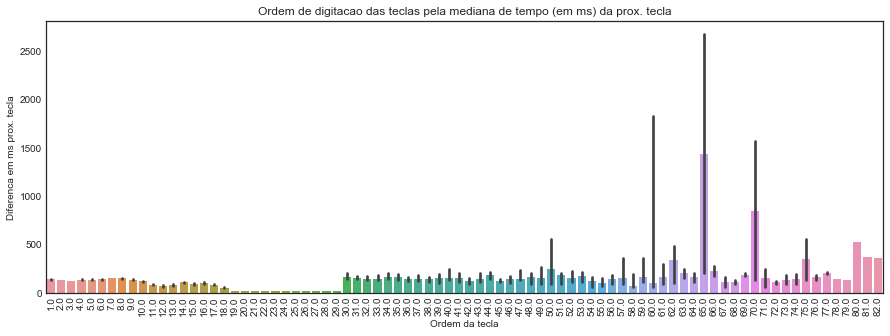

In [22]:
plt.figure(figsize=(15,5))
sns.barplot(x='seq', 
            y='diff_next_key',
            data=df_keydown_grouped,
            estimator=np.median
           )

plt.xticks(rotation= 90)
plt.xlabel('Ordem da tecla')
plt.ylabel('Diferenca em ms prox. tecla')
plt.title("Ordem de digitacao das teclas pela mediana de tempo (em ms) da prox. tecla")
plt.show()

In [23]:
df_keydown_grouped[df_keydown_grouped['index_origin']==36355].sort_values(by=['tick'])

,index_origin,code,tick,seq,tick_next,diff_next_key
317220,36355,95,0,1.0,6,6
317223,36355,106,6,2.0,12,6
317221,36355,99,12,3.0,16,4
317219,36355,75,16,4.0,21,5
317218,36355,72,21,5.0,28,7
317222,36355,101,28,6.0,33,5
317217,36355,54,33,7.0,36,3
317216,36355,48,36,8.0,46,10


### Atualizar no keydown o tempo até a próxima tecla

In [24]:
df_keydown = df_keydown.merge(df_keydown_grouped,how='outer',on=['index_origin','code','seq'])

### Atualizar diff da ultima tecla digitada para 0 (pois não existe tecla posterior)

In [25]:
df_keydown['diff_next_key'][df_keydown.tick_next.isnull()] = 0

In [28]:
# check if total was kept 
df_keyup.count()

code            342996
tick            342996
index_origin    342996
seq             342996
dtype: int64

In [27]:
df_keydown.count()

code             357782
tick_x           357782
index_origin     357782
seq              357782
tick_y           317224
tick_next        317224
diff_next_key    357782
dtype: int64

## Checando duplicidades por code, index e seq

In [29]:
df_keyup.groupby(['code','index_origin','seq']).filter(lambda x: len(x) > 1)

,code,tick,index_origin,seq


### Merge do keyup com o keydown para coletar o tempo que o usuário ficou pressionando a tecla

In [30]:
df_keydown = df_keydown.merge(df_keyup,on=['index_origin','seq'],how='left')

In [31]:
df_keydown['diff_keyup'] = 0
df_keydown['diff_keyup'] = df_keydown['tick'] - df_keydown['tick_x'] 

### Keydown sem Keyup
Existem Keydowns sem keyup. Vamos tratar estes casos separando posteriormente as quantidades

In [32]:
df_keydown[df_keydown.diff_keyup.isnull()]

,code_x,tick_x,index_origin,seq,tick_y,tick_next,diff_next_key,code_y,tick,diff_keyup
24,4,2256,36353,4.0,NaN,NaN,0.0,NaN,NaN,NaN
55,1,0,36348,1.0,0.0,15.0,15.0,NaN,NaN,NaN
56,2,0,36348,2.0,0.0,15.0,15.0,NaN,NaN,NaN
57,3,0,36348,3.0,0.0,15.0,15.0,NaN,NaN,NaN
58,4,15,36348,4.0,NaN,NaN,0.0,NaN,NaN,NaN
59,5,15,36348,5.0,NaN,NaN,0.0,NaN,NaN,NaN
237,1,0,36328,1.0,0.0,376.0,376.0,NaN,NaN,NaN
238,2,376,36328,2.0,376.0,809.0,433.0,NaN,NaN,NaN
239,3,809,36328,3.0,809.0,1376.0,567.0,NaN,NaN,NaN
240,4,1376,36328,4.0,1376.0,1728.0,352.0,NaN,NaN,NaN


In [33]:
df_keydown[df_keydown['index_origin']==36348]

,code_x,tick_x,index_origin,seq,tick_y,tick_next,diff_next_key,code_y,tick,diff_keyup
55,1,0,36348,1.0,0.0,15.0,15.0,NaN,NaN,NaN
56,2,0,36348,2.0,0.0,15.0,15.0,NaN,NaN,NaN
57,3,0,36348,3.0,0.0,15.0,15.0,NaN,NaN,NaN
58,4,15,36348,4.0,NaN,NaN,0.0,NaN,NaN,NaN
59,5,15,36348,5.0,NaN,NaN,0.0,NaN,NaN,NaN


In [34]:
df_keydown[df_keydown.diff_keyup.isnull()].groupby(['index_origin']).filter(lambda x: len(x) > 1)

,code_x,tick_x,index_origin,seq,tick_y,tick_next,diff_next_key,code_y,tick,diff_keyup
55,1,0,36348,1.0,0.0,15.0,15.0,NaN,NaN,NaN
56,2,0,36348,2.0,0.0,15.0,15.0,NaN,NaN,NaN
57,3,0,36348,3.0,0.0,15.0,15.0,NaN,NaN,NaN
58,4,15,36348,4.0,NaN,NaN,0.0,NaN,NaN,NaN
59,5,15,36348,5.0,NaN,NaN,0.0,NaN,NaN,NaN
237,1,0,36328,1.0,0.0,376.0,376.0,NaN,NaN,NaN
238,2,376,36328,2.0,376.0,809.0,433.0,NaN,NaN,NaN
239,3,809,36328,3.0,809.0,1376.0,567.0,NaN,NaN,NaN
240,4,1376,36328,4.0,1376.0,1728.0,352.0,NaN,NaN,NaN
241,5,1728,36328,5.0,1728.0,3911.0,2183.0,NaN,NaN,NaN


## Keyup sem keydown
Vamos manter assim por enquanto pois com as diferenças negativas é provável que o modelo já consiga separar os casos

In [35]:
df_keydown[df_keydown.diff_keyup < 0]

,code_x,tick_x,index_origin,seq,tick_y,tick_next,diff_next_key,code_y,tick,diff_keyup
174,3,4495,36334,3.0,4495.0,5618.0,1123.0,9.0,3094.0,-1401.0
175,4,5618,36334,4.0,5618.0,6989.0,1371.0,10.0,4580.0,-1038.0
176,5,6989,36334,5.0,6989.0,7874.0,885.0,11.0,5693.0,-1296.0
177,6,7874,36334,6.0,NaN,NaN,0.0,12.0,7078.0,-796.0
403,3,1057,36311,3.0,1057.0,1475.0,418.0,14.0,875.0,-182.0
404,4,1475,36311,4.0,1475.0,1854.0,379.0,15.0,1159.0,-316.0
405,5,1854,36311,5.0,1854.0,2128.0,274.0,16.0,1555.0,-299.0
406,6,2128,36311,6.0,2128.0,4100.0,1972.0,17.0,1955.0,-173.0
407,7,4100,36311,7.0,4100.0,7072.0,2972.0,18.0,2220.0,-1880.0
674,4,2536,36283,7.0,2536.0,2600.0,64.0,6.0,3.0,-2533.0


In [36]:
df_keydown[df_keydown.index_origin==32019]

,code_x,tick_x,index_origin,seq,tick_y,tick_next,diff_next_key,code_y,tick,diff_keyup
42540,900,0,32019,1.0,0.0,231.0,231.0,158.0,0.0,0.0
42541,483,231,32019,2.0,231.0,319.0,88.0,900.0,135.0,-96.0
42542,4,319,32019,3.0,319.0,671.0,352.0,483.0,319.0,0.0
42543,485,671,32019,4.0,671.0,951.0,280.0,4.0,423.0,-248.0
42544,186,951,32019,5.0,951.0,1639.0,688.0,485.0,767.0,-184.0
42545,317,1639,32019,6.0,1639.0,2423.0,784.0,186.0,1095.0,-544.0
42546,696,2423,32019,7.0,NaN,NaN,0.0,317.0,1767.0,-656.0


In [37]:
df_keyup[df_keyup.index_origin==32019]

,code,tick,index_origin,seq
0,158,0,32019,1.0
1,900,135,32019,2.0
2,483,319,32019,3.0
3,4,423,32019,4.0
4,485,767,32019,5.0
5,186,1095,32019,6.0
6,317,1767,32019,7.0
7,696,2471,32019,8.0


## quantidade de keydown sem keyup

In [38]:
df_missing_keyup = df_keydown[df_keydown.diff_keyup.isnull()].groupby(['index_origin']).code_x.agg(['count']).reset_index()
df_missing_keyup.columns = ['index_origin','number_missing_keyup']

## quantidade de keydown e keyup

In [39]:
df_number_keydown = df_keydown.groupby(['index_origin']).code_x.agg(['count']).reset_index()
df_number_keydown.columns = ['index_origin','number_keydown']

df_number_keyup = df_keyup.groupby(['index_origin']).code.agg(['count']).reset_index()
df_number_keyup.columns = ['index_origin','number_keyup']

## tempo total de digitação (apenas keydown)

In [40]:
df_max_keydown = df_keydown.groupby(['index_origin'])['tick_x'].agg(['max']).reset_index()

## quantidade distinta de teclas pressionadas
Este tipo de dado não parece ser muito util neste cenário, mas vamos coletar os dados para posterior análise

In [41]:
df_distinct_keydown = pd.DataFrame(df_keydown.groupby(['index_origin']).code_x.nunique()).reset_index()
df_distinct_keydown.columns = ['index_origin','number_distinct_keydown']

## quantidade geral keydown

In [42]:
len(df_keydown.code_x.unique())

1000

## Calcular média, mediana e desvio padrão das diferenças das próx. teclas

In [43]:
df_mean_media_next_key = df_keydown.groupby(['index_origin'])['diff_next_key'].agg(['mean','median','std']).reset_index()
df_mean_media_next_key.columns = ['index_origin','mean_next_key','median_next_key','std_next_key']

## Calcular média, mediana e desvio padrão das diferenças do tempo de release da tecla

In [44]:
df_mean_media_keyup = df_keydown.groupby(['index_origin'])['diff_keyup'].agg(['mean','median','std']).reset_index()
df_mean_media_keyup.columns = ['index_origin','mean_keyup','median_keyup','std_keyup']

# Agrupar os dados no dataframe de treino principal

In [45]:
train.count()

index_origin    36356
target          36356
inputs          36356
dtype: int64

In [46]:
train = train.merge(df_number_keydown,on = ['index_origin'])
train = train.merge(df_number_keyup,on = ['index_origin'],how='left')
train = train.merge(df_missing_keyup,on = ['index_origin'],how='left')
train = train.merge(df_max_keydown,on = ['index_origin'],how='left')
train = train.merge(df_distinct_keydown,on = ['index_origin'],how='left')
train = train.merge(df_mean_media_next_key,on = ['index_origin'],how='left')
train = train.merge(df_mean_media_keyup,on = ['index_origin'],how='left')

In [47]:
train.count()

index_origin               36356
target                     36356
inputs                     36356
number_keydown             36356
number_keyup               35094
number_missing_keyup        4320
max                        36356
number_distinct_keydown    36356
mean_next_key              36356
median_next_key            36356
std_next_key               36356
mean_keyup                 35094
median_keyup               35094
std_keyup                  34942
dtype: int64

## Separação do perfil de digitação (consideramos como muitas teclas distintas quando for acima da mediana)

In [62]:
print('Mediana do numero de teclas distintas : {}'.format(train.number_distinct_keydown.median()))

Mediana do numero de teclas distintas : 8.0


In [48]:
train['distinct_key_type'] = 0
train['distinct_key_type'][train['number_distinct_keydown'] > train.number_distinct_keydown.median()] = 1

## Tratar missings 
Por enquanto apenas iremos zerar os missings

In [49]:
train['number_missing_keyup'][train.number_missing_keyup.isnull()] = 0
train['number_keyup'][train.number_keyup.isnull()] = 0
train['mean_keyup'][train.mean_keyup.isnull()] = 0
train['median_keyup'][train.median_keyup.isnull()] = 0
train['std_keyup'][train.std_keyup.isnull()] = 0

## Analisar Outliers

In [51]:
df_keydown[df_keydown.diff_next_key > df_keydown.diff_next_key.median()]

mediana da dif da prox tecla : 104.0


,code_x,tick_x,index_origin,seq,tick_y,tick_next,diff_next_key,code_y,tick,diff_keyup
9,65,0,36354,1.0,0.0,124.0,124.0,65.0,87.0,87.0
10,66,124,36354,2.0,124.0,453.0,329.0,66.0,256.0,132.0
11,67,453,36354,3.0,453.0,565.0,112.0,67.0,506.0,53.0
12,68,565,36354,4.0,565.0,736.0,171.0,68.0,634.0,69.0
13,69,736,36354,5.0,736.0,1046.0,310.0,69.0,863.0,127.0
15,71,1131,36354,7.0,1131.0,1316.0,185.0,71.0,1229.0,98.0
17,73,1411,36354,9.0,1411.0,1543.0,132.0,73.0,1561.0,150.0
21,1,0,36353,1.0,0.0,202.0,202.0,6.0,71.0,71.0
22,2,202,36353,2.0,202.0,1370.0,1168.0,7.0,286.0,84.0
23,3,1370,36353,3.0,1370.0,2256.0,886.0,8.0,1481.0,111.0


In [52]:
df_keydown[df_keydown.diff_next_key > 10000] # Greater than 10 sec.

,code_x,tick_x,index_origin,seq,tick_y,tick_next,diff_next_key,code_y,tick,diff_keyup
130,427,1632,36340,2.0,1632.0,202816.0,201184.0,427.0,1729.0,97.0
199,413,2355,36332,6.0,2355.0,490676.0,488321.0,413.0,2443.0,88.0
470,81,3399,36305,17.0,3399.0,22718.0,19319.0,81.0,3750.0,351.0
1160,65,0,36233,1.0,0.0,11344.0,11344.0,65.0,16.0,16.0
1789,686,3977,36173,9.0,3977.0,15956.0,11979.0,686.0,3985.0,8.0
2440,461,144,36102,3.0,144.0,1086200.0,1086056.0,461.0,240.0,96.0
2645,864,760,36084,3.0,760.0,14936.0,14176.0,864.0,847.0,87.0
2996,780,5095,36044,3.0,5095.0,84599.0,79504.0,780.0,5271.0,176.0
3888,2,15,35953,2.0,15.0,11796.0,11781.0,1.0,29610.0,29595.0
3889,1,11796,35953,3.0,11796.0,29609.0,17813.0,NaN,NaN,NaN


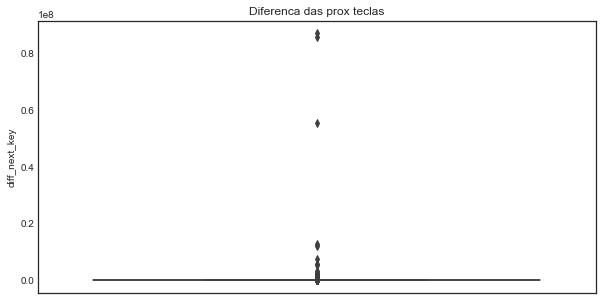

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

fig = plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 1)
sns.set_style("whitegrid")
    
ax = sns.boxplot(y="diff_next_key", data=df_keydown)

ax.set_title('Diferenca das prox teclas')    

f.set_figheight(5)
f.set_figwidth(10)

plt.show()

## Clusterização com kmeans para tentarmos isolar os outliers

In [54]:
from sklearn import preprocessing

df_keydown['seq_scaled'] = 0
df_keydown['diff_next_key_scaled'] = 0

scaler = preprocessing.StandardScaler()

df_keydown[['seq_scaled','diff_next_key_scaled']] = scaler.fit_transform(df_keydown[['seq','diff_next_key']])

In [55]:
from sklearn.cluster import KMeans

X = df_keydown[['seq','diff_next_key']]

kmeans = KMeans(n_clusters=5, random_state=SEED).fit(X)
kmeans.labels_
df_keydown['CLUSTER'] = kmeans.labels_

### Os clusters 1,2,3 e 4 contém os outliers

In [56]:
df_keydown.groupby('CLUSTER').code_x.count()

CLUSTER
0    357755
1         2
2         1
3         3
4        21
Name: code_x, dtype: int64

In [57]:
index_outliers = df_keydown[df_keydown.CLUSTER>0].index_origin.values

### Nova coluna indicativa para os outliers de next key e seq

In [63]:
train['outlier'] = 0
train['outlier'][train.index_origin.isin(index_outliers)] = 1

Ainda existem muitos outliers mas manteremos assim por enquanto

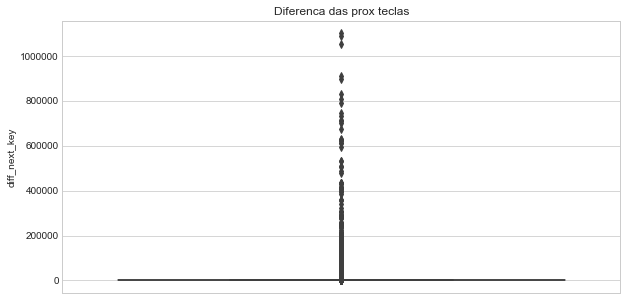

In [64]:
fig = plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 1)
sns.set_style("whitegrid")
    
ax = sns.boxplot(y="diff_next_key", data=df_keydown[df_keydown.CLUSTER==0] )

ax.set_title('Diferenca das prox teclas')    

f.set_figheight(5)
f.set_figwidth(10)

plt.show()

## Person Correlation

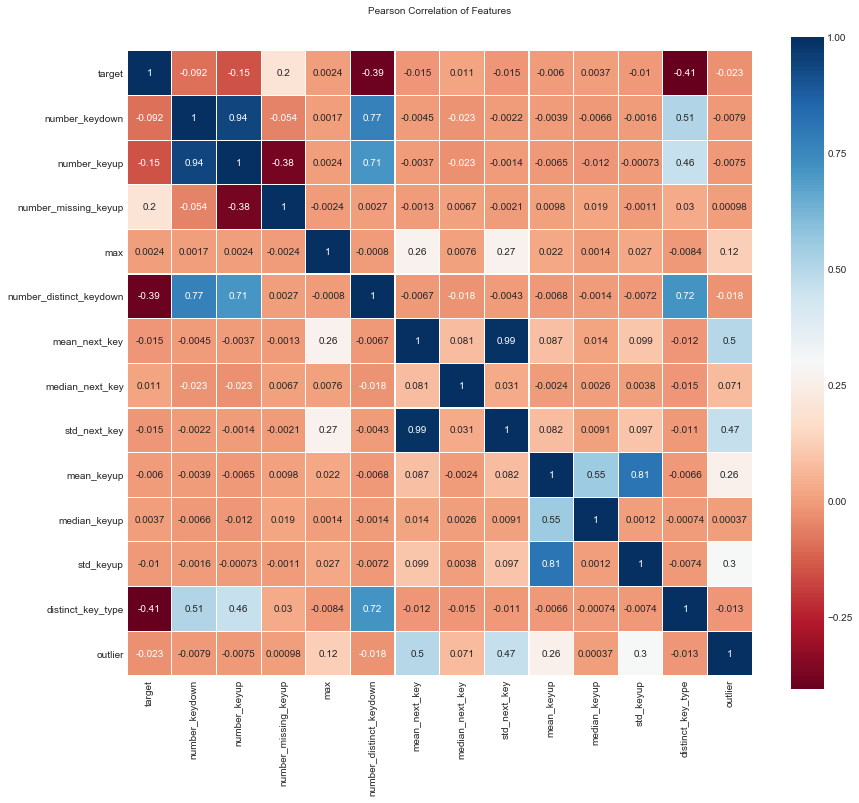

In [65]:
colormap = plt.cm.RdBu

plt.figure(figsize=(14,12))

plt.title('Pearson Correlation of Features', y=1.05, size=10)

sns.heatmap(train.drop(['inputs','index_origin'],axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# Model

### Dividir em treino e teste

In [66]:
columns_to_remove = ['index_origin','target','inputs']

X = train.drop(columns_to_remove,axis=1)
y = train.target

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

### Vamos inicialmente testar com um Gradient Boosting padrão

In [68]:
from sklearn import ensemble

params = {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 2,
          'learning_rate': 0.01, 'verbose': 0,'random_state': SEED}

model = ensemble.GradientBoostingClassifier(**params)

model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=800, subsample=1.0, verbose=0,
              warm_start=False)

### Testamos a acurácia e analisamos a matriz de confusão apenas para efeitos de comparação 
Mais abaixo calcularemos a métrica principal (logloss) 

In [69]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
df_conf_norm = df_confusion / df_confusion.values.sum()
df_conf_norm

0.989548954895
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      3263
          1       0.99      0.99      0.99      4009

avg / total       0.99      0.99      0.99      7272

[[3229   34]
 [  42 3967]]


Predicted,0,1
Actual,,
0,0.444032,0.004675
1,0.005776,0.545517


## Features importance

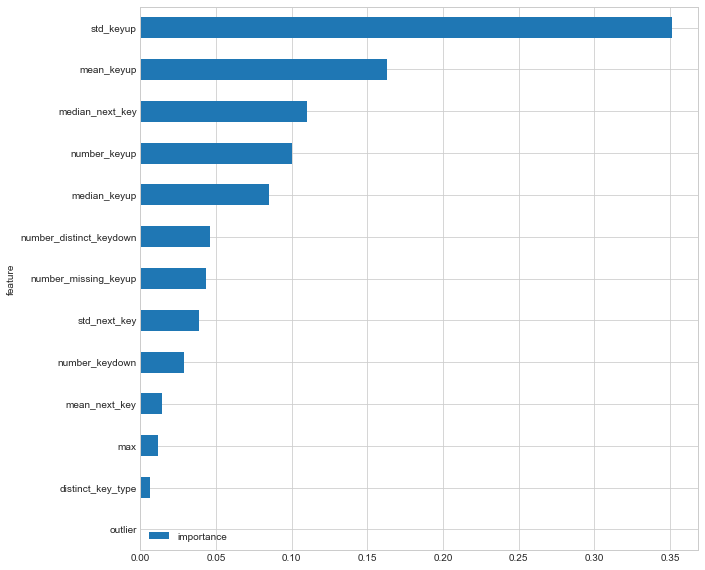

In [70]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features = features.head(20)
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(10, 10))

## Analisar métrica principal (Logloss)

In [71]:
from sklearn.metrics import log_loss

y_pred_proba = model.predict_proba(X_test)
print('Logloss: {}'.format(log_loss(y_test, y_pred_proba)))

Logloss: 0.0365537973157


## Cross-Validation para analisarmos a possibilidade de overfitting

In [72]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss',verbose=0)
print('Logloss: {}'.format(scores.mean()))

Logloss: -0.0389543212926


### Gridsearch GradientBoosting
Otimização apenas do GradientBoosting por questões de overfitting

In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier 

tuned_parameters = [{'n_estimators': [500,1000,2000],
                     'max_depth' : [2],
                     'subsample': [0.4],
                     'min_samples_split':[2],
                     'learning_rate': [0.01] ,
                    
                    }]
#round1: {'min_samples_split': 2, 'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.4}
#round2: {'min_samples_split': 2, 'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.4}
#round3: {'min_samples_split': 2, 'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.4}
#round4: {'min_samples_split': 2, 'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.4}

model = GradientBoostingClassifier()

clf = GridSearchCV(model, tuned_parameters, cv=3, scoring='neg_log_loss')
clf.fit(X_test,y_test)

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [500, 1000, 2000], 'subsample': [0.4], 'learning_rate': [0.01], 'min_samples_split': [2], 'max_depth': [2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [76]:
print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'min_samples_split': 2, 'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.4}


In [77]:
# Random Forest parameters
rf_params = {
    'n_estimators': 2000,
    'verbose': 0,
    'random_state': SEED
}

# Gradient Boosting parameters
gb_params = {'n_estimators': 2000, 
             'max_depth': 2, 
             'min_samples_split': 2,
             'subsample': 0.4,
             'learning_rate': 0.01, 
             'verbose': 0,
             'random_state': SEED}

## Stacking
Rodando um stacking simples com pouca otimização dos hyperparameters.

In [78]:
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from mlxtend.classifier import StackingClassifier

clf1 = RandomForestClassifier(**rf_params)
clf2 = GradientBoostingClassifier(**gb_params)

lr = LogisticRegression(random_state=SEED)

sclf = StackingClassifier(classifiers=[clf1, clf2], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, sclf], 
                      ['Random Forest', 
                       'Gradient Boosting',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='neg_log_loss')
    print("LogLoss: %0.4f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

LogLoss: -0.0234 (+/- 0.00) [Random Forest]
LogLoss: -0.0330 (+/- 0.00) [Gradient Boosting]
LogLoss: -0.0542 (+/- 0.01) [StackingClassifier]


### Usar apenas o Random Forest 
Precisaria adicionar outros modelos mais pesados (como SVM) para fazer stacking porém seria necessário mais tempo de processamento 

In [81]:
clf1.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
            oob_score=False, random_state=800, verbose=0, warm_start=False)

** caso tivesse mais tempo poderia testar outros modelos mais pesados (como SVM, redes neurais,etc) e também rodar um GridSearch maior para otimização dos hiperparametros

## Persistir o modelo

In [82]:
from sklearn.externals import joblib

joblib.dump(clf1,'classification_rf_model_20180729.pkl')

['classification_rf_model_20180729.pkl']